In [182]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
from pathlib import Path
import re

import pickle

sns.set_style('darkgrid')
sns.set_palette("colorblind")

In [183]:
data_dir = os.path.join(Path.cwd().parent, 'datasets')

DF_NAMES = ["essays", "mbti_onehot"]
DF_NAME = DF_NAMES[0]

dataset_dir = os.path.join(data_dir, DF_NAME)
nosep_dir = os.path.join(data_dir, "pattern_mining")
nosep_files_dir = os.path.join(nosep_dir, 'files')
pattern_dir = os.path.join(nosep_dir, 'patterns')
patterns_combined_dir = os.path.join(nosep_dir, "patterns_combined")

stats_dir = os.path.join(dataset_dir, "stats_TRAIN_SIZE-80%")

In [184]:
df_text = pd.read_csv(os.path.join(dataset_dir, 'essays.csv'), index_col=0)
char_cols = [x for x in df_text.columns if x not in ['author', 'text']]
df_text

author                                               text  cEXT  \
0     1997_504851  Well, right now I just woke up from a mid-day ...     0   
1     1997_605191  Well, here we go with the stream of consciousn...     0   
2     1997_687252  An open keyboard and buttons to push. The thin...     0   
3     1997_568848  I can't believe it!  It's really happening!  M...     1   
4     1997_688160  Well, here I go with the good old stream of co...     1   
...           ...                                                ...   ...   
2462     2004_493       I'm home. wanted to go to bed but remembe...     0   
2463     2004_494       Stream of consiousnesssskdj. How do you s...     1   
2464     2004_497  It is Wednesday, December 8th and a lot has be...     0   
2465     2004_498  Man this week has been hellish. Anyways, now i...     0   
2466     2004_499  I have just gotten off the phone with brady. I...     0   

      cNEU  cAGR  cCON  cOPN  
0        1     1     0     1  
1        0     1     0     0  
2        1     0     1     1  
3        0     1     1     0  
4        0     1     0     1  
...    ...   ...   ...   ...  
2462     1     0     1     0  
2463     1     0     0     1  
2464     0     1     0     0  
2465     1     0     0     1  
2466     1     1     0     1  

[2467 rows x 7 columns]

In [185]:
a = []
b = []
for cc in char_cols:
    df_text[cc[1:]] = cc
    
    a.append(df_text[cc].tolist())
    b.append(df_text[cc[1:]].tolist())

a = np.concatenate(a)
b = np.concatenate(b)

df_plot = pd.DataFrame({'Personality trait': b, 'value': a})
df_plot['Personality trait'] = df_plot['Personality trait'].apply(lambda x: x[1:])

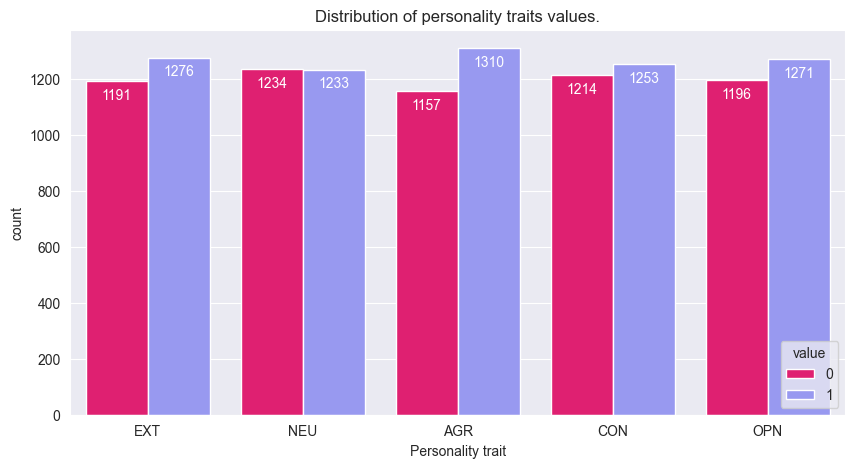

In [186]:
sns.set_style('darkgrid')
sns.set_palette("colorblind")

value_colors = ['#FF006C', '#898AFF']

plt.subplots(figsize=(10, 5))
splot = sns.countplot(data=df_plot, x='Personality trait', hue='value', palette=value_colors, width=0.8)
# splot.bar_label(ax.containers[0])



# for i in splot.containers:
#         splot.bar_label(i, label_type='center', color='lightblue', size=9)

for p in splot.patches:
    splot.annotate(f'{int(p.get_height())}', (p.get_x()+0.1, p.get_height()-65, ), color='white')

plt.title("Distribution of personality traits values.")
legend = plt.legend(loc='lower right')
legend.set_title('value')

# plt.savefig('figures\Essays_ValueCounts.png')
plt.show()

In [187]:
def print_results_scores(results_dir) -> pd.DataFrame:
    """
    Function that reads all pickle files from given directory with results files,
    and returns a pandas dataframes with all concatenated scores.
    """
    
    df_list = []

    for r in os.listdir(results_dir):

        with open(os.path.join(results_dir, r), 'rb') as f:
            results = pickle.load(f)
            f.close()

        for df_name, rd in results.items():
            n = r.split("_")[1].split(".")[0] +"_"+ "".join(re.findall(r'\d+', df_name)) + "_".join(df_name.split("_")[6:])
            df = pd.DataFrame(rd).T.rename({"f1score": n}, axis='columns')[n]
        
            df_list.append(df)

    df_results = pd.concat(df_list, axis=1).T
    
    return df_results

df_results = print_results_scores(os.path.join(stats_dir, r'results')).reset_index(names='name')

df_results = df_results[~df_results['name'].str.contains("5")]
df_results['model'] = df_results.name.apply(lambda x: x.split("_")[0])
df_results['data'] = df_results.name.apply(lambda x: x.split("2")[-1].replace("_spaCy.csv", ""))
df_results['data'] = df_results['data'].replace("spaCy.csv", "raw")
df_results.drop('name', axis=1, inplace=True)
df_results[char_cols] = df_results[char_cols] * 100

df_results

df_t = df_results[['data', 'model'] + char_cols]
df_t[char_cols] = df_t[char_cols].astype(float)
df_t['average'] = df_t[char_cols].sum(axis=1) / 5
df_t['average'] = df_t['average'].round(4)
df_t['std'] = df_t[char_cols].std(axis=1).round(4)
df_t[char_cols] = df_t[char_cols].round(4)

char_cols = ['cOPN', 'cCON', 'cEXT', 'cAGR', 'cNEU']
df_t.columns = [x[1:] if x in char_cols else x for x in df_t.columns ]


df_t.to_csv("figures\ALL_results.csv")
df_t

data                model      EXT      NEU      AGR  \
0                 lemma               KMeans  52.8265  51.2016  51.0539   
1   no_stop_words_lemma               KMeans  53.0395  48.5653  49.6541   
2         no_stop_words               KMeans  52.6269  52.0257  50.8607   
3                   raw               KMeans  52.7274  50.3347  51.1923   
5                 lemma                  LDA  80.5649  80.1619  80.1561   
6   no_stop_words_lemma                  LDA  77.3227  75.9100  75.6933   
7         no_stop_words                  LDA  79.1489  77.3235  75.6531   
8                   raw                  LDA  82.1616  82.1769  81.1853   
10                lemma             LightGBM  87.4321  87.2477  88.9725   
11  no_stop_words_lemma             LightGBM  85.8146  82.5911  83.5534   
12        no_stop_words             LightGBM  84.1576  81.7718  84.7544   
13                  raw             LightGBM  87.6401  87.2477  88.3908   
15                lemma  Logistic-Regression  71.0252  63.2530  67.8693   
16  no_stop_words_lemma  Logistic-Regression  76.9616  70.8445  73.1869   
17        no_stop_words  Logistic-Regression  74.9737  74.8988  78.5982   
18                  raw  Logistic-Regression  73.1898  66.3543  68.4084   
20                lemma          Naive-Bayes  49.1846  55.0890  56.2830   
21  no_stop_words_lemma          Naive-Bayes  44.5319  57.6324  49.8268   
22        no_stop_words          Naive-Bayes  45.5861  50.8357  58.9593   
23                  raw          Naive-Bayes  46.6769  52.7924  57.4899   
25                lemma        Random-forest  73.9757  75.4787  74.1718   
26  no_stop_words_lemma        Random-forest  76.6124  73.8754  74.4539   
27        no_stop_words        Random-forest  74.6315  70.4395  74.6157   
28                  raw        Random-forest  76.9919  74.0801  77.2571   
30                lemma                  SVM  85.2220  86.0264  86.3960   
31  no_stop_words_lemma                  SVM  82.1880  83.6042  82.5802   
32        no_stop_words                  SVM  86.0336  84.8187  84.8156   
33                  raw                  SVM  88.0571  86.0080  85.0242   

        CON      OPN  average     std  
0   50.5846  50.1779  51.1689  1.0106  
1   50.1943  51.6125  50.6131  1.7446  
2   50.3994  52.0213  51.5868  0.9220  
3   51.3468  50.9398  51.3082  0.8821  
5   80.5496  82.7911  80.8447  1.1061  
6   73.8666  80.9623  76.7510  2.6555  
7   78.3235  80.5668  78.2031  1.8556  
8   83.6014  82.1857  82.2622  0.8626  
10  88.0289  89.2711  88.1905  0.9041  
11  83.3768  86.2335  84.3139  1.6095  
12  82.5797  85.8202  83.8167  1.6372  
13  88.6252  92.7126  88.9233  2.1900  
15  68.2808  71.4501  68.3757  3.2779  
16  68.5829  74.0891  72.7330  3.1904  
17  74.0661  76.9117  75.8897  1.8389  
18  70.4114  71.0452  69.8818  2.6072  
20  54.2594  51.7400  53.3112  2.8456  
21  46.7343  49.8827  49.7216  4.9617  
22  48.9563  51.9797  51.2634  4.9365  
23  55.7598  53.9471  53.3332  4.1274  
25  75.1939  77.9176  75.3475  1.5740  
26  77.0527  80.5247  76.5038  2.6263  
27  75.1498  81.1367  75.1947  3.8267  
28  73.8259  81.7545  76.7819  3.2029  
30  86.0272  86.6305  86.0604  0.5345  
31  81.7814  86.6370  83.3582  1.9540  
32  85.2222  87.0292  85.5839  0.9484  
33  85.0202  86.8413  86.1902  1.2914

EXT      NEU      AGR      CON      OPN
13  87.6401  87.2477  88.3908  88.6252  92.7126

Radar plot

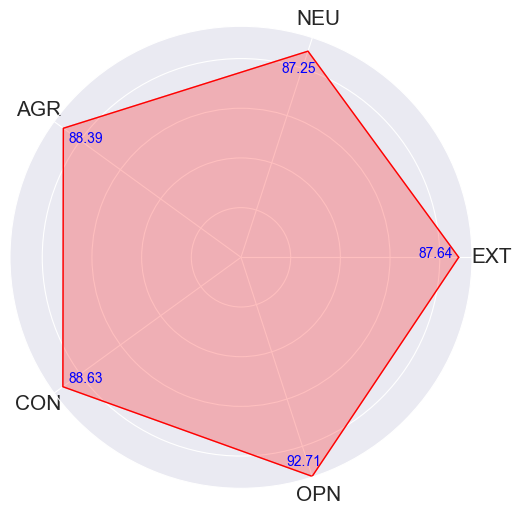

In [215]:
bests = df_t.loc[df_t['average'] == df_t['average'].max(), 
                ['EXT', 'NEU', 'AGR', 'CON', 'OPN']].round(2).squeeze()

# Number of variables we're plotting.
num_vars = len(bests)

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is made circular, so we need to "complete the loop" and append the start to the end.
values = bests.tolist()
values += values[:1]
angles += angles[:1]

# Draw plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw the outline of our data.
ax.fill(angles, values, color='red', alpha=0.25)

# Draw the outline of our data.
ax.plot(angles, values, color='red', linewidth=1)

# Draw each attribute value as a label
for i, (angle, value) in enumerate(zip(angles, values)):

    value1 = value

    if i == 5:
        continue

    elif i == 0:
        # angle += 0.
        value -= 16
        pass

    elif i == 2:
        angle += 0.04
        value -= 5
        pass

    elif i == 3:
        value -= 3
        pass

    elif i == 1:
        angle += 0.1
        value -= 11
        pass

    elif i == 4:
        angle -= 0.1
        value -= 7
        pass

    ax.text(angle, value, str(value1), horizontalalignment='left', size=10, color='blue')

# Add attribute labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(bests.index.tolist(), size=15)

# Remove the yticks and ytick labels
ax.set_yticklabels([])

# Show the plot
plt.savefig('figures/radar_plot.png')
plt.show()


In [8]:
char_cols2 = [x[1:] for x in char_cols]
ds = pd.DataFrame()

for n, g in df_t.groupby("data"):
#     print(g[char_cols].min(), g[char_cols].max())
    
    
    ds.loc[n, char_cols2] = g[char_cols2].mean()

ds.mean(axis=1)

lemma                  71.899846
no_stop_words          71.648331
no_stop_words_lemma    70.570657
raw                    72.668680
dtype: float64

In [179]:
stds = pd.DataFrame()
means = pd.DataFrame()

for n, g in df_t.groupby("model"):
#     print(g[char_cols].min(), g[char_cols].max())
    
    
    stds.loc[n, char_cols2] = g[char_cols2].std()
    means.loc[n, char_cols2] = g[char_cols2].mean()

# amp['Mean'] = x.mean(axis=1)
means = means.reset_index(names='model')


In [10]:
stds['average'] = stds[char_cols2].sum(axis=1) / 5

OPN       CON       EXT       AGR       NEU  \
KMeans               0.807567  0.502947  0.176252  0.704025  1.481704   
LDA                  1.038127  4.096930  2.059383  2.915787  2.813996   
LightGBM             3.196800  3.114757  1.622442  2.670263  2.944063   
Logistic-Regression  2.717314  2.659357  2.531098  4.996874  5.102951   
Naive-Bayes          1.662471  4.278685  1.995570  4.026853  2.933758   
Random-forest        1.686960  1.326477  1.475330  1.433434  2.141290   
SVM                  0.190242  1.872134  2.436377  1.579913  1.154471   

                      average  
KMeans               0.734499  
LDA                  2.584845  
LightGBM             2.709665  
Logistic-Regression  3.601519  
Naive-Bayes          2.979467  
Random-forest        1.612698  
SVM                  1.446627

In [13]:
stds[char_cols2]

OPN       CON       EXT       AGR       NEU
KMeans               0.807567  0.502947  0.176252  0.704025  1.481704
LDA                  1.038127  4.096930  2.059383  2.915787  2.813996
LightGBM             3.196800  3.114757  1.622442  2.670263  2.944063
Logistic-Regression  2.717314  2.659357  2.531098  4.996874  5.102951
Naive-Bayes          1.662471  4.278685  1.995570  4.026853  2.933758
Random-forest        1.686960  1.326477  1.475330  1.433434  2.141290
SVM                  0.190242  1.872134  2.436377  1.579913  1.154471

In [14]:
value_colors = ['#71B1FF', '#A200FF', '#13FFFF', '#74B3CD', '#898AFF', '#DB6DD3', '#FF006C'][::-1]


In [180]:
for i, (n, row) in enumerate(means.iterrows()):
#     plt.plot([x[1:] for x in char_cols], row[char_cols2], label=row['model'], c=value_colors[i], linewidth=2)
    plt.errorbar(char_cols2, row[char_cols2], yerr=stds[char_cols2].loc[row['model']], c=value_colors[i], marker='.')
#     plt.scatter([x[1:] for x in char_cols], row[char_cols2], c=value_colors[i], marker='.')
plt.ylim(0, 100)
plt.title('Mean of results of all datasets.')
plt.ylabel('Weighted F1 Score [%]')
plt.legend()
# plt.savefig('figures/Means_lineplot.png')
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


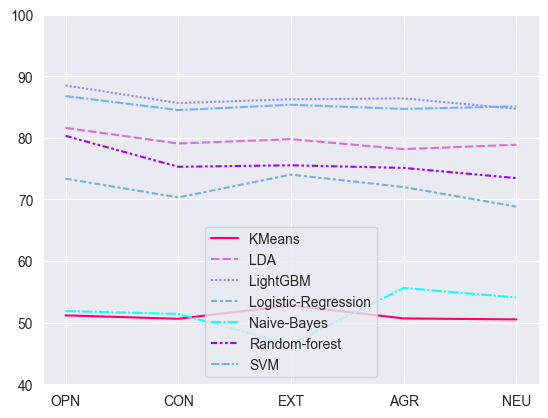

In [16]:
sns.lineplot(data=means.T, palette=value_colors)
plt.ylim(40, 100)
plt.legend()
plt.show()

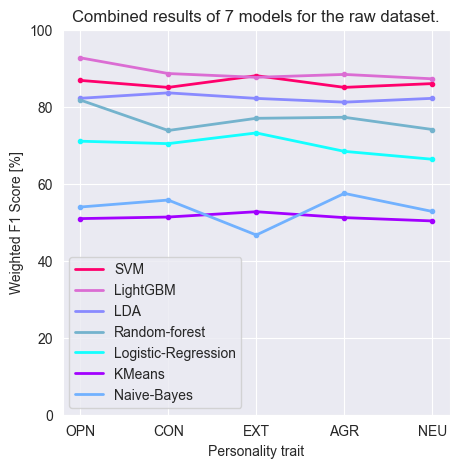

In [19]:
plt.figure(figsize=(5, 5))
for i, (r, row) in enumerate(df_results[df_results['data'] == n].sort_values('cEXT', ascending=False).iterrows()):
    plt.scatter([x[1:] for x in char_cols], row[char_cols], marker='.', c=value_colors[i])
    ax = plt.plot([x[1:] for x in char_cols], row[char_cols], label=row.model, c=value_colors[i], linewidth=2)
plt.ylim(0, 100)
plt.xlabel('Personality trait')
plt.ylabel('Weighted F1 Score [%]')
plt.title(f"Combined results of 7 models for the {n} dataset.")
plt.grid(True)
plt.legend()
#     plt.savefig(f"figures\scores_line_{n}.png")
plt.show()

C:\Users\tt428\AppData\Local\Temp\ipykernel_4236\3171409828.py:31: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.lineplot(data=g, x="model", y="weighted f1 score", hue="Personality trait", palette=value_colors)


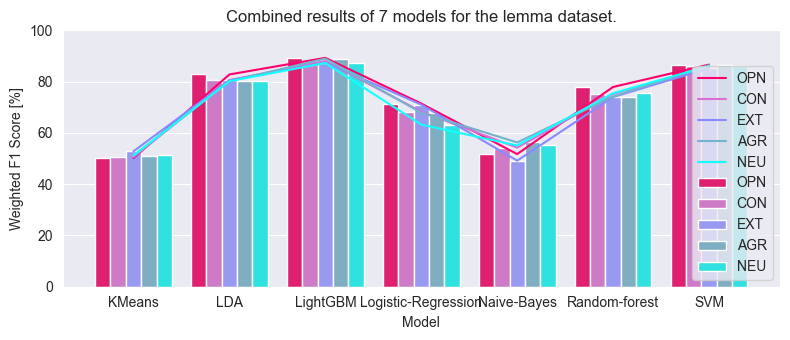

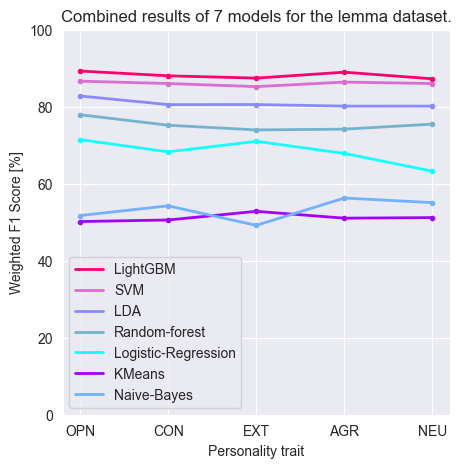

C:\Users\tt428\AppData\Local\Temp\ipykernel_4236\3171409828.py:31: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.lineplot(data=g, x="model", y="weighted f1 score", hue="Personality trait", palette=value_colors)


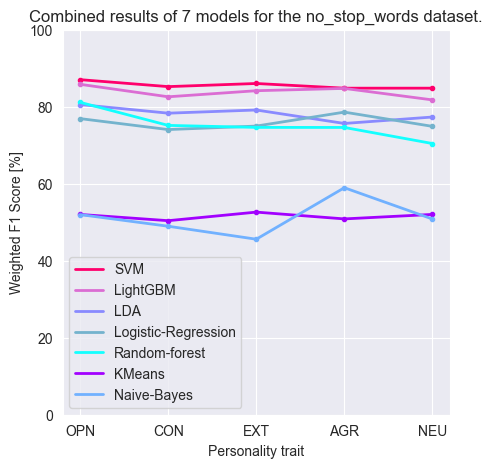

C:\Users\tt428\AppData\Local\Temp\ipykernel_4236\3171409828.py:31: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.lineplot(data=g, x="model", y="weighted f1 score", hue="Personality trait", palette=value_colors)


C:\Users\tt428\AppData\Local\Temp\ipykernel_4236\3171409828.py:31: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.lineplot(data=g, x="model", y="weighted f1 score", hue="Personality trait", palette=value_colors)


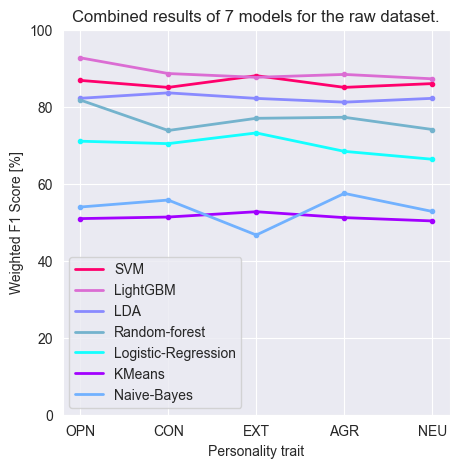

In [18]:
result = []
model = []
data = []
pt = []

for cc in char_cols:
    
    pt.append([cc[1:]]* len(df_results[cc]))
    result.append(df_results[cc].tolist())
    model.append(df_results['model'].tolist())
    data.append(df_results['data'].tolist())
    
result = np.concatenate(result)
model = np.concatenate(model)
data = np.concatenate(data)
pt = np.concatenate(pt)

df_plot = pd.DataFrame({'weighted f1 score': result, 'model': model, 'data_type': data, "Personality trait": pt}).round(2)
df_plot

sns.set_style('darkgrid')
sns.set_palette("colorblind")

value_colors = ['#71B1FF', '#A200FF', '#13FFFF', '#74B3CD', '#898AFF', '#DB6DD3', '#FF006C'][::-1]

for n, g in df_plot.groupby('data_type'):
    plt.figure(figsize=(8, 3.5))
    
#     plt.subplot(1, 2, 1)
    splot = sns.barplot(data=g, x="model", y="weighted f1 score", hue="Personality trait", palette=value_colors, )
    sns.lineplot(data=g, x="model", y="weighted f1 score", hue="Personality trait", palette=value_colors)
    
#     for p in splot.patches:
#         splot.annotate(f'{int(p.get_height())}', (p.get_x()+0.1, p.get_height()-65, ), color='white')
    
#     for i in splot.containers:
#         splot.bar_label(i, label_type='edge', color='black')

#     plt.axhline(g[g["Personality trait"] == 'EXT']['weighted f1 score'].max(), linestyle='dashed', color='violet')
#     plt.axhline(g[g["Personality trait"] == 'NEU']['weighted f1 score'].max(), linestyle='dashed', color='red')
#     plt.axhline(g[g["Personality trait"] == 'AGR']['weighted f1 score'].max(), linestyle='dashed', color='black')
#     plt.axhline(g[g["Personality trait"] == 'CON']['weighted f1 score'].max(), linestyle='dashed', color='yellow')
#     plt.axhline(g[g["Personality trait"] == 'OPN']['weighted f1 score'].max(), linestyle='dashed', color='green')
    plt.ylim(0, 100)
    plt.xlabel("Model")
    plt.title(f"Combined results of 7 models for the {n} dataset.")
    plt.ylabel('Weighted F1 Score [%]')
    plt.legend(loc='lower right')
    plt.tight_layout()
#     plt.savefig(f"figures\scores_bar_{n}.png")
    plt.show()
    
#     plt.subplot(1, 2, 2)
    
    plt.figure(figsize=(5, 5))
    for i, (r, row) in enumerate(df_results[df_results['data'] == n].sort_values('cEXT', ascending=False).iterrows()):
        plt.scatter([x[1:] for x in char_cols], row[char_cols], marker='.', c=value_colors[i])
        ax = plt.plot([x[1:] for x in char_cols], row[char_cols], label=row.model, c=value_colors[i], linewidth=2)
    plt.ylim(0, 100)
    plt.xlabel('Personality trait')
    plt.ylabel('Weighted F1 Score [%]')
    plt.title(f"Combined results of 7 models for the {n} dataset.")
    plt.grid(True)
    plt.legend()
#     plt.savefig(f"figures\scores_line_{n}.png")
    plt.show()
    
# for i, row in g.iterrows():
#     plt.scatter(char_cols, row[char_cols])
#     ax = plt.plot(char_cols, row[char_cols], label=row.model)
# plt.ylim(0, 1)
# plt.legend()
# plt.show()